# Ingeniería de características espaciales

En el aprendizaje automático y la ciencia de datos, a menudo estamos equipados con toneladas de datos. De hecho, dada la constelación de paquetes para consultar servicios de datos, conjuntos de datos gratuitos y de código abierto, y la recopilación rápida y persistente de datos geográficos, simplemente hay demasiados datos para representarlos de manera coherente de una manera única y ordenada. Sin embargo, a menudo necesitamos poder construir funciones útiles a partir de este rico y profundo mar de datos.

Cuando los datos están disponibles, pero aún no se pueden utilizar directamente, la **ingeniería de características** ayuda a construir datos útiles para modelar un fenómeno de interés determinado. En el aprendizaje automático tradicional, la ingeniería de características implica la aplicación de conocimientos de dominio adicionales a la información en bruto para estructurarla de una manera que sea significativa para un modelo. A menudo, esto implica algún tipo de transformación del conjunto de datos original, que es un concepto bien estudiado tanto en la estadística clásica como en los métodos de aprendizaje automático. Mientras que la ingeniería de características siempre se basa en este conocimiento de dominio implícito, **es una parte extremadamente importante de la adaptación de algoritmos de propósito general a problemas únicos o distintivos que enfrenta el científico de datos de todos los días**.

La **geografía** es **una de las formas ubicuas y de mayor calidad de introducir el conocimiento del dominio en un problema**: todo tiene una **posición** tanto en el espacio como en el tiempo. Y, mientras que las cosas que suceden cerca unas de otras en el tiempo no necesariamente tienen una relación fundamental, las cosas que están cerca unas de otras a menudo están relacionadas. Por lo tanto, el espacio es la clave de enlace definitiva , que nos permite conectar diferentes conjuntos de datos para mejorar nuestros modelos y nuestras predicciones. Esto significa que, incluso para datos espaciales, "no geográficos", puede utilizar la ingeniería de características espaciales para crear características útiles y altamente relevantes para su análisis.

En esencia, la ingeniería de características espaciales **es el proceso de desarrollar información adicional a partir de datos sin procesar utilizando el conocimiento geográfico**. Esta destilación de información puede ocurrir entre conjuntos de datos, donde la geografía se usa para vincular información en conjuntos de datos separados; o dentro de conjuntos de datos, donde la **geografía se puede utilizar para aumentar la información disponible** para una muestra tomando prestada de otras cercanas. Este capítulo está estructurado siguiendo esa distinción: para los casos en los que la geografía conecta diferentesconjuntos de datos, adoptamos el término "Coincidencia de mapas", que se utiliza a menudo en la industria; mientras que usamos el concepto de espejo de "Síntesis de mapas" que describe el uso de la estructura geográfica para derivar nuevas características de un conjunto de datos dado. Técnicamente hablando, algunos de los métodos que revisamos son similares en estos dos casos, o incluso los mismos; sin embargo, se pueden aplicar en el contexto de “emparejamiento” o “síntesis”, y las consideramos conceptualmente diferentes, de ahí su inclusión en ambos apartados. A lo largo del capítulo, utilizamos los precios de alquiler nocturno de AirBnB en San Diego, así como conjuntos de datos auxiliares como la elevación o la demografía del censo.

In [64]:
import geopandas
import pandas 
#import libpysal.weights as weights
import contextily
from tobler.area_weighted import area_interpolate
import matplotlib.pyplot as plt
#import cenpy
import numpy
import osmnx
import seaborn
import rasterio
from rasterio.plot import show as rioshow

import warnings
warnings.filterwarnings('ignore')

A lo largo de este capítulo, usaremos un conjunto de datos común al que queremos agregar más información a través de la geografía. Para la ilustración, usaremos el conjunto de propiedades AirBnB . Vamos a leerlo:

In [3]:
import geopandas
airbnbs = geopandas.read_file('./data/regression_db.geojson')
airbnbs

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,2,1.0,1.0,1.0,University City,1,16.924951,0,79.0,4.369448,13882013,1,0,0,0,0,0,1,0,POINT (-117.21635 32.87142)
6106,6,2.0,2.0,2.0,Marina,0,2.821975,0,295.0,5.686975,13882245,0,1,0,0,0,1,0,0,POINT (-117.16342 32.71036)
6107,1,1.0,1.0,1.0,North Hills,0,1.990988,0,65.0,4.174387,13882335,0,0,1,0,0,0,1,0,POINT (-117.12986 32.74252)
6108,3,1.0,1.0,1.0,East Village,1,2.060319,0,170.0,5.135798,13882606,1,0,0,0,0,1,0,0,POINT (-117.15070 32.71322)


## ¿Qué es la ingeniería de características espaciales? 

En esencia, la ingeniería de características espaciales es el **proceso de desarrollar información adicional a partir de datos sin procesar utilizando el conocimiento geográfico**. Esta síntesis podría ocurrir entre conjuntos de datos, donde la geografía se utiliza para vincular muestras en conjuntos de datos separados; o dentro de conjuntos de datos, donde la geografía se puede utilizar para tomar prestada información de muestras cercanas. Construyendo vínculos entre Los conjuntos de datos a menudo se denominan "Coincidencia de mapas", mientras que nosotros usamos el término "Síntesis de mapas" para describir el uso de la estructura geográfica para derivar nuevas características de los datos existentes. En este capítulo se cubrirán ambos tipos de ingeniería de características geográficas, comenzando primero con varios métodos para la correspondencia de mapas al modelar los precios de alquiler de AirBnB por noche en San Diego.

Para ayudarnos a discutir esto, un vocabulario es útil. En este capítulo cubriremos algunos tipos diferentes de características, las cuales se pueden construir en operaciones de Síntesis de mapas o Coincidencia de mapas:

- Una **característica de resumen espacial** mide los atributos de las observaciones que tienen alguna relación espacial preespecificada con nuestras observaciones objetivo. Esto incluye

    - tomando el **valor promedio o mediano de las características dentro de un vecindario** de cada observación objetivo.
    
    - el **rezago espacial** , utilizado en capítulos anteriores de este libro (por ejemplo, los capítulos 3, 6 y 11), es una especie de característica de resumen espacial, ya que refleja el **valor promedio de los datos en la vecindad alrededor de cada punto**.
    
    - Otros tipos de características de resumen espacial pueden incluir el **recuento de observaciones dentro de una distancia determinada** o la desviación estándar de diez observaciones más cercanas.
    
    - Las características de resumen generalmente incluyen **características interpoladas** que implican una transferencia de información de un soporte espacial a otro, como cuando las ubicaciones de destino no son las mismas que las ubicaciones en nuestros datos auxiliares. Las características interpoladas también se vuelven significativamente más complejas cuando los datos son reales , como se discutirá más adelante en este capítulo.

- Una **característica de proximidad** mide la **distancia desde la observación de un objetivo a alguna otra observación o posición en el mapa**. Esto podría hacerse en un contexto de correspondencia de mapas, como hicimos antes con la distancia al Parque Balboa, o podría hacerse en un contexto de síntesis de mapas midiendo la distancia a la otra observación más cercana.







## Ingeniería de características usando la correspondencia de mapas 

El espacio es la clave de enlace definitiva; la coincidencia de mapas se trata de explotar este recurso. La información geográfica se recopila a diferentes escalas, se agrega mediante delineaciones geográficas personalizadas y, en última instancia, se almacena en diferentes conjuntos de datos. El modelado y el aprendizaje automático generalmente requieren el uso de datos alineados y estructurados de manera coherente; Para reunir conjuntos de datos geográficos dispares, el científico de datos debe poder transferir la información expresada para una geografía a otra. Aquí es donde la **coincidencia de mapa**s viene al rescate. Al usar la ubicación geográfica, podemos conectar conjuntos de datos que no tienen una clave común o que de otra manera no tienen ninguna relación. Este es un "truco de magia" que podemos lograr debido a la ubicación que sería mucho más difícil, o imposible, con datos que carecen de información espacial.

Los detalles y la dificultad de esta transferencia de información de una geografía a otra dependen de la naturaleza de la “fuente” y el “destino”, y de la precisión con la que queramos realizar dicha transferencia. En este contexto, siempre hay un compromiso inevitable entre precisión y sofisticación: por lo general, es posible una transferencia más precisa a expensas de técnicas más avanzadas y complejas. Su costo adicional al aplicarlos, tanto en términos de carga cognitiva por parte del científico de datos como en términos de cálculo, debe ponderarse de forma individual: a veces necesitamos las mejores estimaciones posibles, a toda costa; a veces "suficientemente bueno" es, bueno, suficientemente bueno.

En esta sección, cubrimos algunos casos que consideramos representan los enfoques más comunes y ampliamente utilizados. Comenzamos con situaciones en las que tenemos dos conjuntos de datos puntuales y todo lo que necesitamos calcular son estadísticas descriptivas de un conjunto de datos a las observaciones del otro. Cambiamos el tipo de datos y consideramos cómo adjuntar información de una cuadrícula continua, almacenada en un archivo ráster, a un conjunto de puntos. Luego mostramos el caso equivalente para “mover” información para una geografía poligonal a un dataset de puntos. Todos estos son casos que, en su forma más simple, involucran principalmente operaciones GIS tradicionales (por ejemplo, construcción de búfer, combinaciones espaciales) y poco en la forma de modelado estadístico. Como ejemplo de un caso más complicado, cubrimos la transferencia de información de una geografía poligonal a otra geografía poligonal diferente. Para este caso final, pero también como un comentario más general, intentamos incluir ejemplos que capturen la esencia del método, pero manteniendo la técnica lo más simple posible. Para casi cualquiera de estos casos que cubrimos, el lector puede encontrar técnicas más sofisticadas que generalmente producen estimaciones más precisas. Siempre que sea posible, intentamos señalizarlos.

### Contando características cercanas

Un primer enfoque, conceptualmente sencillo, es **aumentar nuestro conjunto de datos contando cuántos puntos de un conjunto de datos diferente se encuentran en las proximidades de cada observación**. Por ejemplo, es posible que deseemos saber cuántos **bares y restaurantes** tiene cada AirBnB dentro de un radio determinado. Este recuento puede convertirse en una característica adicional de nuestro conjunto de datos, almacenado en una nueva columna de airbnbs.

Para obtener información sobre la ubicación de restaurantes y bares, podemos descargarla directamente **desde OpenStreetMap** usando **osmnx**. Primero consultamos todos los puntos de interés (PDI) dentro del área que cubren nuestros puntos, y luego filtramos todo excepto los restaurantes y bares. Para eso, necesitamos un polígono que cubra todos nuestros airbnbs puntos. Del Capítulo 8, podemos recordar que hay algunos cascos diferentes que se pueden usar. **Usaremos el casco convexo aquí, que es el polígono convexo más pequeño que cubre todos los puntos del conjunto.**

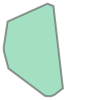

In [4]:
#Obtenemos casco convexo de nuestros datos geoespaciales:
airbnbs_ch = airbnbs.unary_union.convex_hull
airbnbs_ch

Usando este polígono, podemos usar el **osmnx** paquete para buscar **puntos de interés (POI) de OpenStreetMap**. Podemos hacer que nuestra solicitud sea más manejable solicitando solo puntos de interés que se encuentren dentro de categorías específicas. A continuación, solicitaremos PDI dentro de San Diego que sean **"restaurantes" o "bares"**, de acuerdo con sus metadatos almacenados en OpenStreetMap. Una vez devuelto, solo mantenemos algunas columnas para mantener la tabla pequeña y ordenada:

In [5]:
#Realizamos la consulta mediante osmns pasándole el polígono sobre el que realizar la consulta
import osmnx
%time
pois = osmnx.geometries_from_polygon(
    airbnbs_ch, #polígono 
    tags={"amenity": ['restaurant', 'bar']} #obtener restaurantes y bares (más tags: https://wiki.openstreetmap.org/wiki/Map_features)
)[["unique_id", "osmid", "amenity", "cuisine", "name", "geometry"]]

Wall time: 0 ns


El fragmento de código anterior envía una consulta al servidor de OpenStreetMap para obtener los datos sobre las comodidades. 

In [6]:
pois

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,amenity,cuisine,name,geometry
0,node/273607070,273607070,restaurant,italian,Leucadia,POINT (-117.22469 32.86232)
1,node/273607369,273607369,restaurant,sushi,Subarashi,POINT (-117.22469 32.86205)
2,node/274193511,274193511,restaurant,thai,Thai Time III,POINT (-117.18378 32.82139)
3,node/274363369,274363369,restaurant,NaN,Sipz Fusion Cafe,POINT (-117.17386 32.83364)
4,node/276540072,276540072,restaurant,chinese,Shanghai Cafe,POINT (-117.22443 32.86269)
...,...,...,...,...,...,...
1339,way/934163140,934163140,restaurant,NaN,NaN,"POLYGON ((-116.98570 32.84346, -116.98564 32.8..."
1340,way/934163149,934163149,restaurant,breakfast;pancake,IHOP,"POLYGON ((-116.98574 32.83911, -116.98553 32.8..."
1341,way/934163151,934163151,restaurant,italian,Olive Garden,"POLYGON ((-116.98326 32.83909, -116.98304 32.8..."
1342,way/940772369,940772369,restaurant,mexican,Cotijas Cocina Mexicana,"POLYGON ((-117.22916 32.74069, -117.22925 32.7..."


Esto nos proporciona todas las ubicaciones dentro de nuestro casco convexo que están etiquetadas como "restaurante" o "bar" en sus metadatos en OpenStreetMap. En general, esto nos proporciona alrededor de 1300 puntos de interés:

In [7]:
pois.groupby('amenity').amenity.count()

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


amenity
bar            306
restaurant    1038
Name: amenity, dtype: int64

Una vez cargado pois como GeoDataFrame, echemos un vistazo a su ubicación, en comparación con los puntos de AirBnB:

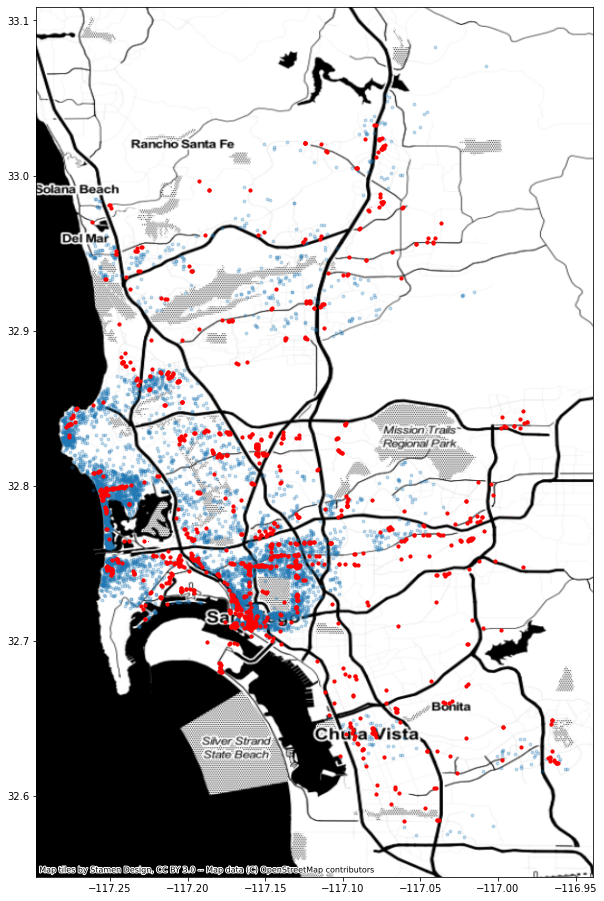

In [8]:
f, ax = plt.subplots(1, figsize = (16, 16))
airbnbs.plot(ax = ax, marker = '.',alpha=0.25)
pois.plot(ax = ax, color = 'r', markersize = 10)
contextily.add_basemap(
    ax, 
    crs=airbnbs.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
plt.show()

Ahora, para algunos ingenieros de funciones, puede ser extremadamente útil saber si un AirBnB está ubicado en una ubicación "caliente", con muchos restaurantes y bares para elegir. Alternativamente, si los AirBnB son muy remotos, es posible que no sean tan lucrativos para reservas cortas y costosas de "escapadas urbanas". Es decir, los usuarios de AirBnB pueden decidir reservar estadías donde hay muchas oportunidades para comer y beber y, por lo tanto, pueden estar dispuestos a pagar más por el mismo alojamiento. **Podríamos predecir mejor los precios si conocemos la escena de la bebida y la cena cerca de AirBnB**.

Por lo tanto, podemos diseñar funciones en los datos de AirBnB utilizando los puntos de interés cercanos. Para hacer esto, podemos crear una nueva función para el conjunto de datos de AirBnB, es decir, una **nueva columna en airbnbs**, que incorpora información sobre **cuántos puntos de interés hay cerca de cada propiedad**. Este tipo de "recuento de características" es útil en aplicaciones donde la mera presencia de características cercanas puede afectar la cantidad que estamos modelando.

Para hacer este tipo de ingeniería de características, veamos primero lo que tenemos que hacer a nivel conceptual:

1. Decide qué hay cerca . Esto determinará **qué tan lejos vamos de cada AirBnB al contar el número de bares y restaurantes "cercanos"**. Para este ejemplo, usaremos un búfer de **500 metros**, que es aproximadamente la distancia de una caminata tranquila de diez minutos.

2. Para cada AirBnB, determine si los puntos de interés se encuentran a una caminata de 10 minutos sin prisas.

3. Cuente cuántos PDI hay dentro del radio especificado de cada AirBnB.

Al final de este procedimiento, tenemos la cantidad de bares y restaurantes que se encuentran a poca distancia a pie del AirBnB, lo que podría ser útil para predecir el precio de cada AirBnB.

Con esto, traduzcamos ahora la lista anterior en código. Para la parte 1, necesitamos poder medir distancias en metros. Sin embargo, airbnbs originalmente se expresa en grados, ya que se proporciona en términos de ubicaciones en latitud y longitud (CRS:4326):

In [9]:
airbnbs.crs

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Además, pois también se proporcionan en términos de latitud y longitud:

In [10]:
pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Por lo tanto, necesitamos convertir esto en un sistema de coordenadas con el que sea más fácil trabajar. Aquí, usaremos una proyección común para el mapeo en California, la proyección de California Albers (CRS:3311):

In [11]:
airbnbs_albers = airbnbs.to_crs(epsg=3311)
pois_albers = pois.to_crs(epsg=3311)

In [12]:
pois_albers.crs

<Projected CRS: EPSG:3311>
Name: NAD83(HARN) / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Con esto, podemos crear el radio de 500m alrededor de cada AirBnB (generando un polígono). Esto a menudo se denomina almacenamiento en búfer , donde una forma se dilata en un radio determinado.



In [13]:
airbnbs_albers['buffer_500m'] = airbnbs_albers.buffer(500)
airbnbs_albers

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,buffer_500m
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,0,1,0,0,1,0,0,POINT (269312.639 -580195.744),"POLYGON ((269812.639 -580195.744, 269810.232 -..."
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,0,1,0,0,0,1,0,0,POINT (257694.376 -577191.922),"POLYGON ((258194.376 -577191.922, 258191.968 -..."
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,...,1,0,0,0,0,0,1,0,POINT (268236.085 -580308.812),"POLYGON ((268736.085 -580308.812, 268733.677 -..."
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,...,0,0,1,0,0,0,1,0,POINT (266568.078 -560652.692),"POLYGON ((267068.078 -560652.692, 267065.671 -..."
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,...,0,0,1,0,0,0,1,0,POINT (261003.776 -581770.057),"POLYGON ((261503.776 -581770.057, 261501.368 -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,2,1.0,1.0,1.0,University City,1,16.924951,0,79.0,4.369448,...,1,0,0,0,0,0,1,0,POINT (260803.624 -567437.818),"POLYGON ((261303.624 -567437.818, 261301.216 -..."
6106,6,2.0,2.0,2.0,Marina,0,2.821975,0,295.0,5.686975,...,0,1,0,0,0,1,0,0,POINT (266294.991 -585120.702),"POLYGON ((266794.991 -585120.702, 266792.584 -..."
6107,1,1.0,1.0,1.0,North Hills,0,1.990988,0,65.0,4.174387,...,0,0,1,0,0,0,1,0,POINT (269336.861 -581465.947),"POLYGON ((269836.861 -581465.947, 269834.454 -..."
6108,3,1.0,1.0,1.0,East Village,1,2.060319,0,170.0,5.135798,...,1,0,0,0,0,1,0,0,POINT (267479.261 -584768.573),"POLYGON ((267979.261 -584768.573, 267976.853 -..."


Ahora, abb_buffer contiene un círculo de 500 metros alrededor de cada AirBnB.

Con estos, podemos contar el número de puntos de interés que se encuentran dentro de estas áreas mediante una combinación/unión espacial (sjoin). 

In [14]:
joined = geopandas.sjoin(
    pois_albers, #bares-restuarantes
    airbnbs_albers.set_geometry('buffer_500m')[['id', 'buffer_500m']], #polígonos de 500m airbnb
    op="within"
)
joined

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,amenity,cuisine,name,geometry,index_right,id
0,node/273607070,273607070,restaurant,italian,Leucadia,POINT (260051.558 -568468.188),656,2043418
1,node/273607369,273607369,restaurant,sushi,Subarashi,POINT (260052.774 -568498.836),656,2043418
4,node/276540072,276540072,restaurant,chinese,Shanghai Cafe,POINT (260074.930 -568426.869),656,2043418
0,node/273607070,273607070,restaurant,italian,Leucadia,POINT (260051.558 -568468.188),991,3113120
1,node/273607369,273607369,restaurant,sushi,Subarashi,POINT (260052.774 -568498.836),991,3113120
...,...,...,...,...,...,...,...,...
1273,way/256639910,256639910,restaurant,burger,Bareback Grill,"POLYGON ((257296.891 -575647.498, 257310.765 -...",2198,6516452
1290,way/391845131,391845131,restaurant,seafood,The Fish Market,"POLYGON ((256578.371 -555557.792, 256601.557 -...",5790,13642602
1329,way/706439411,706439411,restaurant,NaN,NaN,"POLYGON ((261325.500 -582114.145, 261333.398 -...",4,38245
1329,way/706439411,706439411,restaurant,NaN,NaN,"POLYGON ((261325.500 -582114.145, 261333.398 -...",37,172519


El objeto unido resultante joined contiene **una fila para cada par de PDI y AirBnB que están vinculados**. 

A partir de ahí, podemos aplicar una operación de agrupado (groupby), utilizando el ID de AirBnB, y **contar cuántos puntos de interés tiene cada AirBnB dentro de los 500 m de distancia**:

In [15]:
poi_count = joined.groupby("id")["osmid"].count().to_frame('poi_count')
poi_count

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,poi_count
id,
6,12
5570,7
9553,12
38245,1
69385,8
...,...
13882013,11
13882245,42
13882335,9


El resultado indexa en los ID de AirBnB, por lo que podemos asignarlo a la airbnbstabla original. En este caso, sabemos por construcción que los AirBnB que faltan en poi_count no tienen ningún punto de interés dentro de los 500 m, por lo que podemos completar los valores que faltan en la columna con ceros.

In [16]:
airbnbs_w_counts = airbnbs_albers.merge(
    poi_count, 
    left_on='id', 
    right_index=True
).fillna({"poi_count": 0})
airbnbs_w_counts

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,buffer_500m,poi_count
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,1,0,0,1,0,0,POINT (269312.639 -580195.744),"POLYGON ((269812.639 -580195.744, 269810.232 -...",12
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,1,0,0,0,1,0,0,POINT (257694.376 -577191.922),"POLYGON ((258194.376 -577191.922, 258191.968 -...",7
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,...,0,0,0,0,0,1,0,POINT (268236.085 -580308.812),"POLYGON ((268736.085 -580308.812, 268733.677 -...",12
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,...,0,1,0,0,0,1,0,POINT (261003.776 -581770.057),"POLYGON ((261503.776 -581770.057, 261501.368 -...",1
12,6,2.5,3.0,4.0,Mission Bay,0,11.783530,1,250.0,5.521461,...,0,1,0,0,1,0,0,POINT (257512.027 -576940.892),"POLYGON ((258012.027 -576940.892, 258009.619 -...",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,2,1.0,1.0,1.0,University City,1,16.924951,0,79.0,4.369448,...,0,0,0,0,0,1,0,POINT (260803.624 -567437.818),"POLYGON ((261303.624 -567437.818, 261301.216 -...",11
6106,6,2.0,2.0,2.0,Marina,0,2.821975,0,295.0,5.686975,...,1,0,0,0,1,0,0,POINT (266294.991 -585120.702),"POLYGON ((266794.991 -585120.702, 266792.584 -...",42
6107,1,1.0,1.0,1.0,North Hills,0,1.990988,0,65.0,4.174387,...,0,1,0,0,0,1,0,POINT (269336.861 -581465.947),"POLYGON ((269836.861 -581465.947, 269834.454 -...",9
6108,3,1.0,1.0,1.0,East Village,1,2.060319,0,170.0,5.135798,...,0,0,0,0,1,0,0,POINT (267479.261 -584768.573),"POLYGON ((267979.261 -584768.573, 267976.853 -...",6


Podemos visualizar ahora la distribución de recuentos para tener una idea de cómo se organizan las propiedades AirBnB "bien servidas" en el espacio:

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


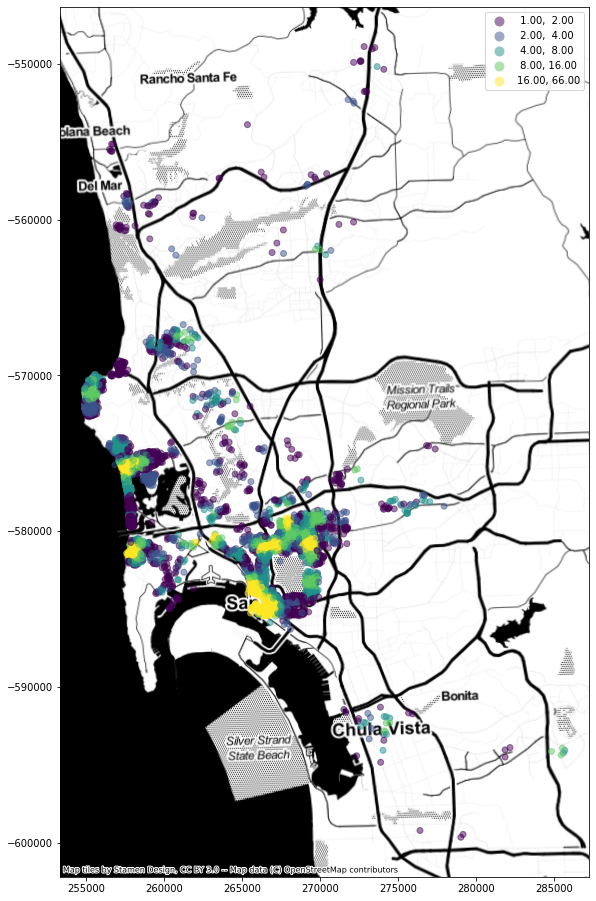

In [17]:
f, ax = plt.subplots(1, figsize=(16, 16))
airbnbs_w_counts.plot(
    column="poi_count",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=airbnbs_albers.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
plt.show()

### Asignar valores de puntos desde superficies: elevación de AirBnBs 

Acabamos de ver cómo contar puntos alrededor de cada observación en un conjunto de datos de puntos. En otros casos, podríamos enfrentarnos a un desafío relacionado pero diferente: transferir el valor de un punto particular en una superficie a un punto en un conjunto de datos diferente.

Para hacer esto más accesible, ilustremos el contexto con una pregunta de ejemplo: **¿cuál es la elevación de cada propiedad AirBnB?** Para responder a esta pregunta, requerimos, al menos, lo siguiente:

1) Una muestra de **ubicaciones** de propiedades de AirBnB.

2) Un conjunto de **datos de elevación**. Usaremos aquí la superficie DEM de la NASA para el área de San Diego.

Traigamos la superficie de elevación:

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


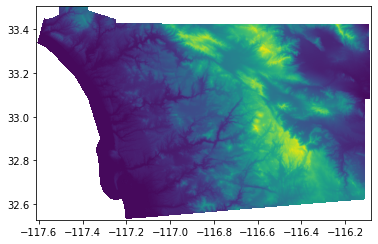

In [18]:
dem = rasterio.open("./data/nasadem_sd.tif")
rioshow(dem);

Primero, verifiquemos que el CRS esté alineado con nuestra muestra de ubicaciones de puntos:



In [19]:
dem.crs

CRS.from_epsg(4326)

Hemos abierto el archivo con rasterio, que todavía no ha leído todo el conjunto de datos. Esta característica nos permite utilizar este enfoque con archivos que son potencialmente muy grandes, ya que solo se leen en la memoria los datos solicitados.

Para extraer un conjunto discreto de valores de la superficie de elevación en dem, podemos usar sample. Para una sola ubicación, así es como funciona:

In [20]:
list(dem.sample([(-117.24592208862305, 32.761619109301606)]))

[array([7], dtype=int16)]

Ahora, podemos aplicar esta lógica a una secuencia de coordenadas. Para eso, necesitamos extraerlos del geometry objeto:



In [21]:
abb_xys = pandas.DataFrame({"X": airbnbs.geometry.x, "Y": airbnbs.geometry.y}).to_records(index=False)
abb_xys

rec.array([(-117.12970522, 32.75399316), (-117.25253317, 32.78421162),
           (-117.14120839, 32.75326632), ...,
           (-117.12985693, 32.74252225), (-117.15069763, 32.71321916),
           (-117.21813283, 32.92168793)],
          dtype=[('X', '<f8'), ('Y', '<f8')])

In [22]:
elevation = pandas.DataFrame(
    dem.sample(abb_xys),
    columns=["Elevation"],
    index=airbnbs.index
)
elevation.head()

,Elevation
0,112
1,3
2,99
3,114
4,30


Ahora que tenemos una tabla con la elevación de cada propiedad AirBnB, podemos trazar las elevaciones del sitio en un mapa para una inspección visual:



C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


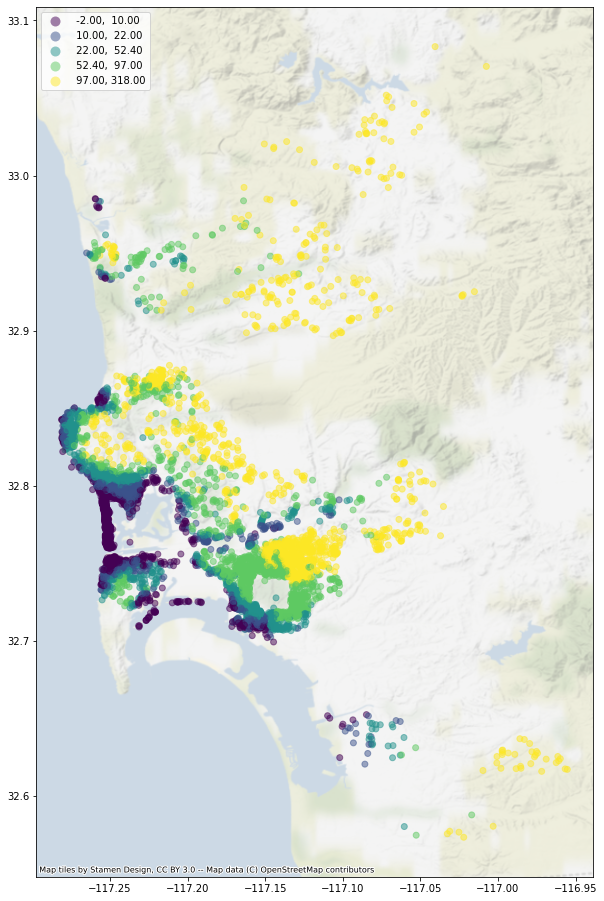

In [23]:
f, ax = plt.subplots(1, figsize=(16, 16))
airbnbs.join(
    elevation
).plot(
    column="Elevation",
    scheme="quantiles",
    legend=True,
    alpha=0.5,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=airbnbs.crs.to_string(), 
    source=contextily.providers.Stamen.TerrainBackground,
    alpha=0.5
)

### Interpolación de puntos usando scikit-learn 

En el ejemplo anterior, hemos transferido información de una superficie (almacenada en una capa ráster) a un conjunto de puntos; es decir, hemos pasado de la superficie a los puntos. A veces, sin embargo, no tenemos el lujo de una superficie prefabricada. En cambio, todo lo que tenemos disponible es un conjunto de puntos con medidas para la variable de interés que no coinciden con los puntos para los que queremos la información. En esta situación, una solución en la que podemos confiar es la **“interpolación espacial”**. Para un campo geográfico continuo medido en un conjunto de puntos, los métodos de “interpolación espacial” **nos brindan una forma de adivinar el valor que tomaría un campo en sitios que no medimos**.

Hay muchos métodos sofisticados con los que se puede hacer esto. 
- **Kriging**, común en el subcampo de las estadísticas espaciales llamado "geoestadística", es una de esas prácticas basadas en la teoría de la **regresión del proceso gaussiano**. 
- Otro enfoque común, la **regresión ponderada geográficamente**, proporciona **estimaciones de modelos únicas en cada punto de control, así como predicciones para lugares donde no hay datos**. 

Aquí, sin embargo, usaremos un muy básico **k-Algoritmo de predicción del vecino más cercano (KNN)** scikit-learnpara demostrar el proceso. Este proceso seleccionará los **10 listados más cercanos y luego calculará la predicción utilizando un promedio ponderado de estas observaciones más cercanas**. Para mantener las predicciones relativamente consistentes, crearemos una interpolación solo para listados que sean casas / apartamentos completos con dos dormitorios:

In [24]:
from sklearn.neighbors import KNeighborsRegressor

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
two_bed_homes = airbnbs[airbnbs['bedrooms']==2 & airbnbs['rt_Entire_home/apt']]

In [26]:
two_bed_home_locations = numpy.column_stack(
    (two_bed_homes.geometry.x, two_bed_homes.geometry.y)
)
two_bed_home_locations[:10]

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-117.25839672,   32.80854653],
       [-117.24683514,   32.75057048],
       [-117.15283799,   32.75173354],
       [-117.25159972,   32.76473873],
       [-117.24471021,   32.74097711],
       [-117.2518276 ,   32.93523019],
       [-117.14405391,   32.70807602],
       [-117.1434337 ,   32.74946806],
       [-117.13906285,   32.71533892],
       [-117.12865252,   32.71993986]])

Para trazar la superficie interpolada, también debemos construir una cuadrícula de ubicaciones para las que haremos predicciones. Esto se puede hacer usando numpy.meshgrid, que construye todas las combinaciones de las dimensiones de entrada como una cuadrícula de salidas.

In [27]:
xmin, ymin, xmax, ymax = airbnbs.total_bounds
x, y = numpy.meshgrid(
    numpy.linspace(xmin, xmax), numpy.linspace(ymin,ymax)
)

Text(0.5, 1.0, 'Y values')

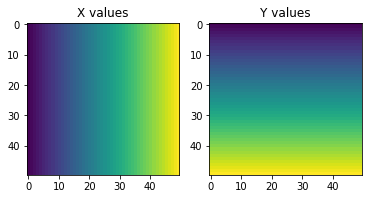

In [28]:
f,ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[1].imshow(y)
ax[0].set_title('X values')
ax[1].set_title('Y values')

Con estas coordenadas, podemos hacer un GeoDataFrame que contenga las celdas de la cuadrícula en las que nos gustaría predecir:

In [29]:
grid = numpy.column_stack((x.flatten(), y.flatten()))
grid_df = geopandas.GeoDataFrame(
    geometry=geopandas.points_from_xy(
        x=x.flatten(), y=y.flatten())
)

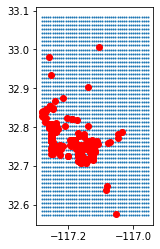

In [30]:
ax = grid_df.plot(markersize=1)
two_bed_homes.plot(ax=ax, color='red');

Una vez hecho esto, ahora podemos construir las predicciones. Primero entrenamos el modelo:



In [31]:
model = KNeighborsRegressor(
    n_neighbors=10, weights='distance'
).fit(two_bed_home_locations, two_bed_homes.price)

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Y luego predecimos en las celdas de la cuadrícula:



In [32]:
predictions = model.predict(grid)

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

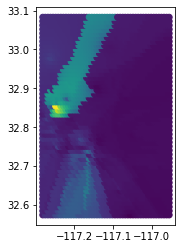

In [33]:
grid_df.plot(predictions)

Puede ver que la superficie se vuelve más lisa a medida que aumenta la cantidad de vecinos más cercanos a considerar:

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


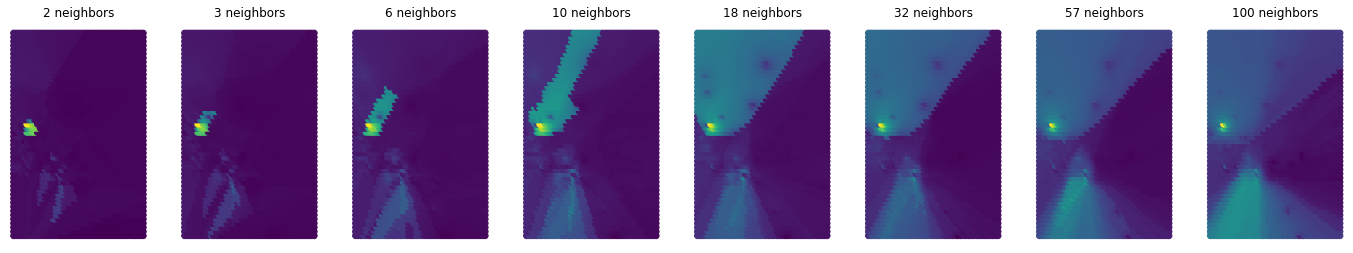

In [34]:
f,ax = plt.subplots(1,8, figsize=(24,8))
for i,k_neighbors in enumerate(numpy.geomspace(2, 100, 8).astype(int)):
    facet = ax[i]
    predictions = KNeighborsRegressor(
        n_neighbors=k_neighbors, weights='distance'
    ).fit(
        two_bed_home_locations, two_bed_homes.price
    ).predict(grid)
    grid_df.plot(predictions, ax=facet)
    facet.axis('off')
    facet.set_title(f"{k_neighbors} neighbors")

Centrarse en el centro de San Diego cuenta la historia con un poco más de claridad, ya que hay más puntos que mostrar. El número creciente de vecinos más cercanos aumenta la suavidad de la superficie interpolada.

In [35]:
central_sd_bounds = [-117.179832, 32.655563, -117.020874, 32.769909]
central_xmin, central_ymin, central_xmax, central_ymax = central_sd_bounds

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
central_x, central_y = numpy.meshgrid(
    numpy.linspace(central_xmin, central_xmax), 
    numpy.linspace(central_ymin, central_ymax)
)
central_grid = numpy.column_stack(
    (central_x.flatten(), central_y.flatten())
)
central_grid_df = geopandas.GeoDataFrame(
    geometry=geopandas.points_from_xy(
        x=central_x.flatten(), y=central_y.flatten()
    )
)

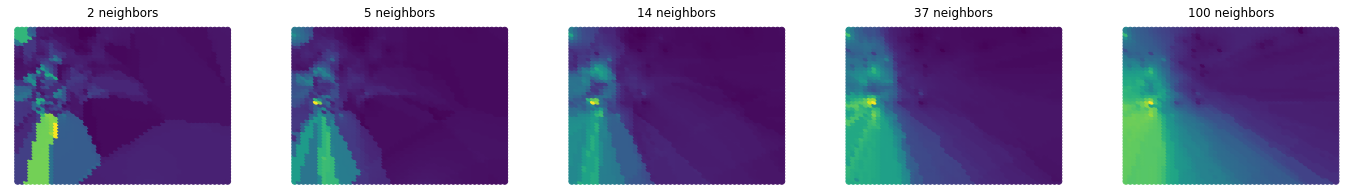

In [37]:
f,ax = plt.subplots(1,5, figsize=(24,8), sharex=True, sharey=True)

for i,k_neighbors in enumerate(numpy.geomspace(2, 100, 5).astype(int)):
    facet = ax[i]
    predictions = KNeighborsRegressor(
        n_neighbors=k_neighbors, weights='distance'
    ).fit(
        two_bed_home_locations, two_bed_homes.price
    ).predict(central_grid)
    central_grid_df.plot(predictions, ax=facet)
    facet.axis('off')
    facet.set_title(f"{k_neighbors} neighbors")

Se implementan muchos más de estos métodos scikit-learn.neighbors, así como métodos de 'kriging' **GSTools** y 'regresión ponderada geográficamente' en **mgwr**.

### Polígono al punto 

Ahora pasamos a un caso en el que la información que nos interesa hacer coincidir con nuestro conjunto de puntos se almacena para una geografía poligonal. Por ejemplo, nos gustaría conocer la densidad de población del barrio en el que se encuentra cada AirBnB. **Para determinar la densidad, descargaremos estimaciones de población a nivel del tramo del censo y "transferiremos" esas estimaciones a cada punto de AirBnB**. Geográficamente, el único desafío aquí es encontrar el polígono contenedor para cada punto y luego realizar lo que en el lenguaje de las bases de datos espaciales se conoce como “unión espacial”, mediante la cual vinculamos las dos capas a través de su conexión espacial.

Analicemos el **número de habitantes** de la Encuesta de la Comunidad Estadounidense para tramos en San Diego:


In [39]:
# %%time
# acs = cenpy.products.ACS()
# sd_pop = acs.from_msa(
#     "San Diego, CA",
#     level = "tract",
#     variables=['B02001_001E']
# )

El fragmento de código anterior envía una consulta al servidor de la Oficina del Censo para obtener los datos de San Diego. Tenga en cuenta que requiere conectividad a Internet para funcionar. Si está trabajando en el libro sin conectividad, una versión en caché del conjunto de datos está disponible en la carpeta de datos y se puede leer como:

In [44]:
sd_pop = geopandas.read_file("./data/sd_census.gpkg")

Y calcule la densidad de población:

In [46]:
sd_pop["density"] = sd_pop["B02001_001E"] / sd_pop.to_crs(epsg=3311).area # densidad de hab. = numéro de hab./ area del polígono
sd_pop

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,GEOID,B02001_001E,NAME,state,county,tract,geometry,density
0,06073018511,5205.0,"Census Tract 185.11, San Diego County, California",06,073,018511,"POLYGON ((-13063789.970 3922505.030, -13063789...",0.003081
1,06073017701,5299.0,"Census Tract 177.01, San Diego County, California",06,073,017701,"POLYGON ((-13059537.230 3907015.040, -13059431...",0.001813
2,06073019302,7836.0,"Census Tract 193.02, San Diego County, California",06,073,019302,"POLYGON ((-13056382.100 3924172.840, -13056362...",0.003138
3,06073008006,3928.0,"Census Tract 80.06, San Diego County, California",06,073,008006,"POLYGON ((-13055008.980 3870449.060, -13054968...",0.002637
4,06073008003,4154.0,"Census Tract 80.03, San Diego County, California",06,073,008003,"POLYGON ((-13053579.300 3869456.240, -13053548...",0.005534
...,...,...,...,...,...,...,...,...
623,06073016502,7645.0,"Census Tract 165.02, San Diego County, California",06,073,016502,"POLYGON ((-13018923.880 3869854.630, -13018923...",0.003635
624,06073016701,9808.0,"Census Tract 167.01, San Diego County, California",06,073,016701,"POLYGON ((-13020147.390 3873927.910, -13020142...",0.001573
625,06073010015,3062.0,"Census Tract 100.15, San Diego County, California",06,073,010015,"POLYGON ((-13029090.680 3836923.460, -13029087...",0.000076
626,06073021206,3065.0,"Census Tract 212.06, San Diego County, California",06,073,021206,"POLYGON ((-13002757.840 3875229.320, -13002735...",0.000072


Ahora, para "transferir" estimaciones de densidad a cada AirBnB, podemos confiar en la unión espacial en geopandas:

In [47]:
j = geopandas.sjoin(airbnbs, sd_pop.to_crs(airbnbs.crs))
j

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,rt_Shared_room,geometry,index_right,GEOID,B02001_001E,NAME,state,county,tract,density
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,POINT (-117.12971 32.75399),501,06073001300,6102.0,"Census Tract 13, San Diego County, California",06,073,001300,0.007705
78,2,1.0,1.0,2.0,North Hills,0,2.414891,0,130.0,4.867534,...,0,POINT (-117.13288 32.74976),501,06073001300,6102.0,"Census Tract 13, San Diego County, California",06,073,001300,0.007705
136,2,1.0,1.0,1.0,North Hills,0,3.204460,0,40.0,3.688879,...,0,POINT (-117.12689 32.75494),501,06073001300,6102.0,"Census Tract 13, San Diego County, California",06,073,001300,0.007705
317,4,2.5,2.0,2.0,North Hills,0,2.790359,0,280.0,5.634790,...,0,POINT (-117.13129 32.75289),501,06073001300,6102.0,"Census Tract 13, San Diego County, California",06,073,001300,0.007705
490,2,1.0,1.0,1.0,North Hills,0,2.313440,0,65.0,4.174387,...,0,POINT (-117.13646 32.75031),501,06073001300,6102.0,"Census Tract 13, San Diego County, California",06,073,001300,0.007705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,6,1.0,2.0,2.0,Mission Bay,0,39.971482,1,175.0,5.164786,...,0,POINT (-117.00749 33.07032),548,06073020710,1600.0,"Census Tract 207.10, San Diego County, California",06,073,020710,0.000062
5855,4,1.0,1.0,1.0,Northwest,1,9.722319,0,114.0,4.736198,...,0,POINT (-117.10841 32.65023),261,06073021900,5684.0,"Census Tract 219, San Diego County, California",06,073,021900,0.000535
6026,2,1.0,1.0,1.0,Northwest,1,9.507209,0,98.0,4.584967,...,0,POINT (-117.10982 32.65184),261,06073021900,5684.0,"Census Tract 219, San Diego County, California",06,073,021900,0.000535
6061,2,1.0,1.0,1.0,Northwest,0,13.589190,0,45.0,3.806662,...,0,POINT (-117.08578 32.62062),348,06073012600,4739.0,"Census Tract 126, San Diego County, California",06,073,012600,0.000662


El resultado es una tabla con una fila por AirBnB y una columna para cada atributo que teníamos originalmente para las propiedades, así como los del tramo donde se encuentra el área:



In [48]:
j.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6110 entries, 0 to 6068
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Interpolación de área a área

El caso final de coincidencia de mapas que consideramos es la transferencia de información de un polígono / geografía de área a otro diferente. Este es un caso de uso común cuando un análisis requiere datos que se proporcionan en diferentes niveles de agregación y diferentes delineaciones de límites.

Existe una gran cantidad de literatura sobre este problema bajo el paraguas del mapeo dasimétrico. La idea conceptual es relativamente sencilla: **queremos distribuir valores de un conjunto de polígonos al otro en función de la cantidad de "geografía" que se comparte**. En su caso más simple, podemos hacer esto en función del área. 

En este caso, **asignaremos valores de la geografía de origen al destino en función de cuánto comparten**. Ilustremos esto con un ejemplo. Llamaremos a la geografía para la que tenemos datos la "fuente", y aquella a la que queremos transferir los datos el "destino". Si el polígono A en el destino está compuesto por el 50% del polígono 1 en la fuente, el 30% del polígono 2 y el 20% del polígono 3, la estimación de A será un promedio ponderado entre los valores de 1, 2 y 3, donde los pesos son 0,5, 0,3 y 0,2, respectivamente. **Por supuesto, subyacente a este ejercicio está la suposición implícita de que los valores que nos interesan se distribuyen uniformemente dentro de cada polígono en la fuente y el destino**. En algunos casos, esta es una suposición válida o, al menos, no introduce errores críticos; en otros, esto no es aceptable. El mapeo dasimétrico ha propuesto una gran cantidad de sofisticaciones que intentan generar estimaciones más realistas y que pueden incorporar información adicional.

Para implementar el mapeo dasimétrico en Python, la mejor opción es **'toblerun'** paquete de la federación PySAL diseñado exactamente para este objetivo. Mostraremos aquí el caso más simple, el de la interpolación de áreas donde la distribución se estima en función del área, pero el paquete también proporciona enfoques más sofisticados.

Por ejemplo, necesitamos dos capas de polígono. Nos quedaremos con San Diego y usaremos el conjunto de secciones censales y la capa de cuadrícula hexagonal H3 . Nuestro objetivo será crear estimaciones de población para cada hexágono.

Primero, carguemos la cuadrícula H3:

In [49]:
h3 = geopandas.read_file("./data/sd_h3_grid.gpkg")

Estamos listos para interpolar:

In [50]:
interpolated = area_interpolate(
    source_df=sd_pop.to_crs(epsg=3311),
    target_df=h3.to_crs(epsg=3311),
    extensive_variables=["B02001_001E"], 
    intensive_variables=["density"]
)

Están sucediendo bastante en la celda de arriba, descomprimámoslo:

- Recuerde que este método distribuye los valores de los datos según el área, por lo que tiene sentido tener una estimación precisa de la extensión de cada polígono. Para hacer eso, **convertimos cada geografía a Albers Equal ( EPSG:3311), que se expresa en metros**, usando to_crs.

- *area_interpolate* Luego, el método toma los GeoDataFrame objetos de origen y de destino usando la misma convención de nomenclatura que tenemos en nuestra explicación.

- Además, necesitamos especificar **qué variables** nos gustaría interpolar. aquí, Tobler hace una distinción:

    - Variables ***extensas*** o valores absolutos como recuentos, agregados, etc. (que usamos para la población B02001_001E)

    - Variables ***intensivas*** , como tasas, ratios, etc. (que seleccionamos para densidad ya que es el ratio de población sobre área)

Un buen primer enfoque para examinar la salida es comparar la fuente y el destino visualmente. Aquí está la población total:

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


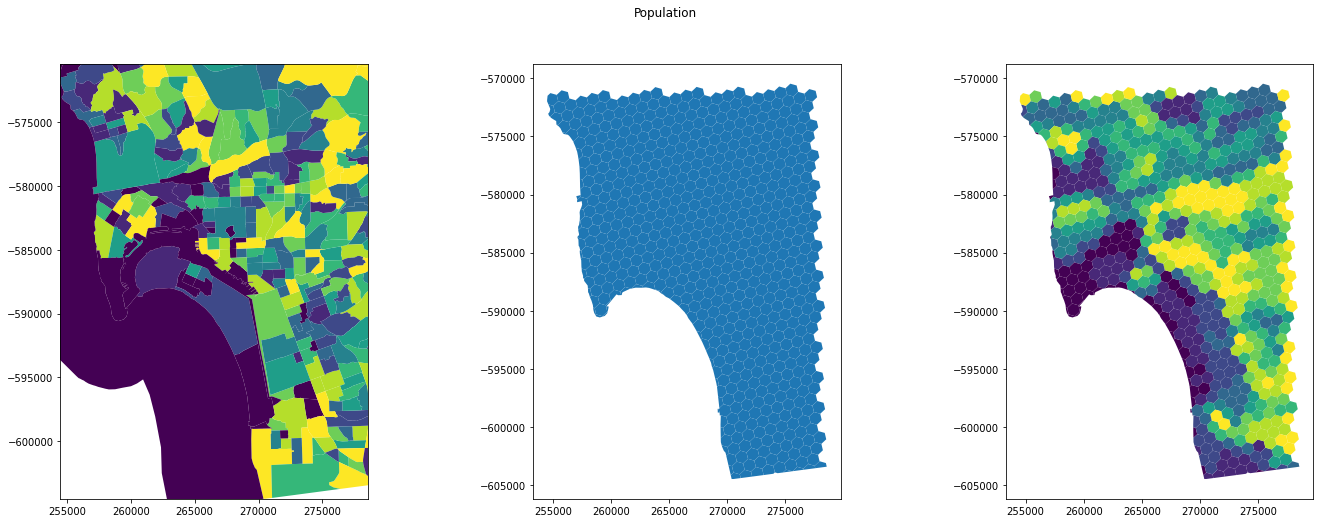

In [53]:
f, axs = plt.subplots(1, 3, figsize=(24, 8))

minX, minY, maxX, maxY = interpolated.total_bounds
sd_pop.to_crs(epsg=3311).cx[minX:maxX, minY:maxY].plot(
    column="B02001_001E", 
    scheme="quantiles", 
    k=10,
    ax=axs[0]
)

h3.to_crs(epsg=3311).plot(ax=axs[1], markersize=0.5)

interpolated.plot(
    column="B02001_001E",
    scheme="quantiles",
    k=10,
    ax=axs[2]
)

axs[0].set_xlim(minX, maxX)
axs[0].set_ylim(minY, maxY)

f.suptitle("Population")

plt.show()

Y densidad:

C:\Users\Julen Montes\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


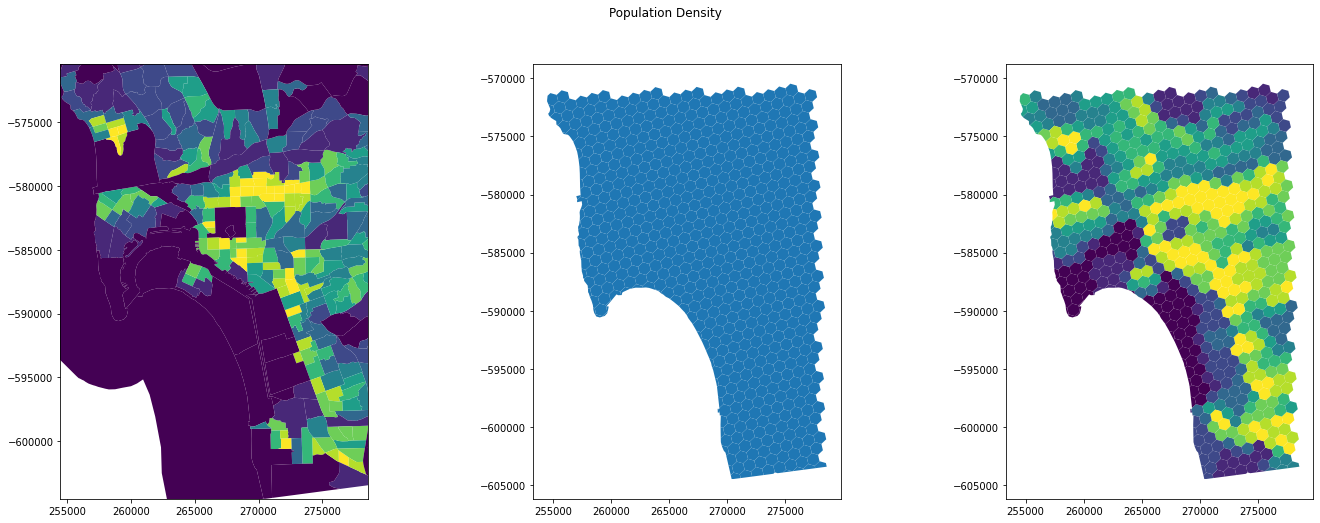

In [54]:
f, axs = plt.subplots(1, 3, figsize=(24, 8))

minX, minY, maxX, maxY = interpolated.total_bounds
sd_pop.to_crs(epsg=3311).cx[minX:maxX, minY:maxY].plot(
    column="density", 
    scheme="quantiles", 
    k=10,
    ax=axs[0]
)

h3.to_crs(epsg=3311).plot(ax=axs[1], markersize=0.5)

interpolated.plot(
    column="density",
    scheme="quantiles",
    k=10,
    ax=axs[2]
)

axs[0].set_xlim(minX, maxX)
axs[0].set_ylim(minY, maxY)

f.suptitle("Population Density")

plt.show()

## Ingeniería de características usando la síntesis de mapas 

La **ingeniería de características con coincidencia de mapas** es **más útil cuando tiene información adicional para usar en el análisis**. Y, con la gran cantidad de datos disponibles gratuitamente de censos, satélites y proveedores abiertos de información geográfica voluntaria como OpenStreetMap, la coincidencia de mapas puede ser una herramienta muy poderosa para enriquecer y mejorar sus análisis. Sin embargo, a veces también es útil examinar solo los datos que tiene y usar la estructura espacial interna para crear mejores características o mejores modelos. Si bien esto se puede hacer usando modelos espacialmente explícitos (como los que se cubren en el Capítulo 11), también es posible usar la síntesis de mapas para construir características espaciales y mejorar sus predicciones.

Existe una gran cantidad de funciones de síntesis de mapas. Además de los dos tipos de características que se analizan en la correspondencia de mapas, existen otros tipos de características útiles que se pueden utilizar en la síntesis de mapas que se discutirán a continuación. Primero, volveremos a las características de resumen espacial. En segundo lugar, examinaremos algunas características de regionalización , que detectan y aprovechan los grupos geográficos en los datos para mejorar la predicción.

### Características de resumen espacial en la síntesis de mapas 
Al igual que en la coincidencia de mapas, puede utilizar características de resumen espacial en la síntesis de mapas para realizar mejores predicciones. Un método claro implica la **construcción de medidas de resumen espacial de sus datos de entrenamiento**. Esto se hace de la misma manera que en la comparación de mapas, excepto que ahora solo podemos referirnos a los datos disponibles. Por lo tanto, **es posible que deseemos determinar si los AirBnB cercanos están "compitiendo" con cada AirBnB**. Podríamos hacer esto encontrando la distancia al AirBnB más cercano con la misma cantidad de habitaciones, ya que dos listados cercanos que también albergan la misma cantidad de personas probablemente competirán entre sí por los inquilinos.



#### Búferes de distancia dentro de una sola tabla 
Podríamos hacer esto construyendo un DistanceBand objeto de peso, que considere AirBnB como "vecinos" si están dentro del umbral de distancia.

In [61]:
# d500_w = weights.DistanceBand.from_dataframe(
#     airbnbs_albers, threshold=500, silence_warnings=True
# )